# Comparison of WordRank, Word2Vec and FastText

[Wordrank](https://arxiv.org/pdf/1506.02761v3.pdf) is a fresh new approach to the word embeddings, which formulates it as a ranking problem. That is, given a word w, it aims to output an ordered list (c1, c2, · · ·) of context words such that words that co-occur with w appear at the top of the list. This formulation fits naturally to popular word embedding tasks such as word similarity/analogy since instead of the likelihood of each word, we are interested in finding the most relevant words in a given context<sup>[1]</sup>.

This notebook accompanies a more theoretical blog post [here](https://rare-technologies.com/wordrank-embedding-crowned-is-most-similar-to-king-not-word2vecs-canute/).

Gensim is used to train and evaluate the word2vec models. Analogical reasoning and Word Similarity tasks are used for comparing the models. Word2vec and FastText embeddings are trained using the skipgram architecture here.

# Download and preprocess data

In [1]:
import nltk
from gensim.parsing.preprocessing import strip_punctuation, strip_multiple_whitespaces

# Only the brown corpus is needed in case you don't have it.
nltk.download('brown') 

# Generate brown corpus text file
with open('brown_corp.txt', 'w+') as f:
    for word in nltk.corpus.brown.words():
        f.write('{word} '.format(word=word))
    f.seek(0)
    brown = f.read()

# Preprocess brown corpus
with open('proc_brown_corp.txt', 'w') as f:
    proc_brown = strip_punctuation(brown)
    proc_brown = strip_multiple_whitespaces(proc_brown).lower()
    f.write(proc_brown)

# Set WR_HOME and FT_HOME to respective directory root
WR_HOME = 'wordrank/'
FT_HOME = 'fastText/'

# download the text8 corpus (a 100 MB sample of preprocessed wikipedia text)
import os.path
if not os.path.isfile('text8'):
    !wget -c http://mattmahoney.net/dc/text8.zip
    !unzip text8.zip

[nltk_data] Downloading package brown to /Users/parul/nltk_data...
[nltk_data]   Package brown is already up-to-date!


# Train Models
For training the models yourself, you'll need to have Gensim, FastText and Wordrank set up on your machine.

In [2]:
MODELS_DIR = 'models/'
!mkdir -p {MODELS_DIR}

from gensim.models import Word2Vec
from gensim.models.wrappers import Wordrank
from gensim.models.word2vec import Text8Corpus

# fasttext params
lr = 0.05
dim = 100
ws = 5
epoch = 5
minCount = 5
neg = 5
loss = 'ns'
t = 1e-4

w2v_params = {
    'alpha': 0.025,
    'size': 100,
    'window': 15,
    'iter': 5,
    'min_count': 5,
    'sample': t,
    'sg': 1,
    'hs': 0,
    'negative': 5
}

wr_params = {
    'size': 100,
    'window': 15,
    'iter': 91,
    'min_count': 5
}

def train_models(corpus_file, output_name):
    # Train using word2vec
    output_file = '{:s}_gs'.format(output_name)
    if not os.path.isfile(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file))):
        print('\nTraining word2vec on {:s} corpus..'.format(corpus_file))
        # Text8Corpus class for reading space-separated words file
        %time gs_model = Word2Vec(Text8Corpus(corpus_file), **w2v_params); gs_model
        locals()['gs_model'].save_word2vec_format(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file)))
        print('\nSaved gensim  model as {:s}.vec'.format(output_file))
    else:
        print('\nUsing existing model file {:s}.vec'.format(output_file))

    # Train using fasttext
    output_file = '{:s}_ft'.format(output_name)
    if not os.path.isfile(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file))):
        print('Training fasttext on {:s} corpus..'.format(corpus_file))
        %time !{FT_HOME}fasttext skipgram -input {corpus_file} -output {MODELS_DIR+output_file}  -lr {lr} -dim {dim} -ws {ws} -epoch {epoch} -minCount {minCount} -neg {neg} -loss {loss} -t {t}
    else:
        print('\nUsing existing model file {:s}.vec'.format(output_file))
        
    # Train using wordrank
    output_file = '{:s}_wr'.format(output_name)
    output_dir = 'model' # directory to save embeddings and metadata to
    if not os.path.isfile(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file))):
        print('\nTraining wordrank on {:s} corpus..'.format(corpus_file))
        %time wr_model = Wordrank.train(WR_HOME, corpus_file, output_dir, **wr_params); wr_model
        locals()['wr_model'].save_word2vec_format(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file)))
        print('\nSaved wordrank model as {:s}.vec'.format(output_file))
    else:
        print('\nUsing existing model file {:s}.vec'.format(output_file))
     
    # Loading ensemble embeddings
    output_file = '{:s}_wr_ensemble'.format(output_name)
    if not os.path.isfile(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file))):
        print('\nLoading ensemble embeddings (vector combination of word and context embeddings)..')
        %time wr_model = Wordrank.load_wordrank_model(os.path.join(WR_HOME, 'model/wordrank.words'), os.path.join(WR_HOME, 'model/meta/vocab.txt'), os.path.join(WR_HOME, 'model/wordrank.contexts'), sorted_vocab=1, ensemble=1); wr_model
        locals()['wr_model'].wv.save_word2vec_format(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file)))
        print('\nSaved wordrank (ensemble) model as {:s}.vec'.format(output_file))
    else:
        print('\nUsing existing model file {:s}.vec'.format(output_file))
                
train_models(corpus_file='proc_brown_corp.txt', output_name='brown')


Training word2vec on proc_brown_corp.txt corpus..
CPU times: user 1min 7s, sys: 527 ms, total: 1min 8s
Wall time: 46.8 s

Saved gensim model as brown_gs.vec
Training fasttext on proc_brown_corp.txt corpus..
Read 1M words
Number of words:  14042
Number of labels: 0
Progress: 99.6%  words/sec/thread: 58810  lr: 0.000179  loss: 2.348125  eta: 0h0m Progress: 20.1%  words/sec/thread: 30702  lr: 0.039934  loss: 2.296231  eta: 0h0m Progress: 100.0%  words/sec/thread: 58810  lr: 0.000000  loss: 2.348125  eta: 0h0m 
CPU times: user 842 ms, sys: 284 ms, total: 1.13 s
Wall time: 41.3 s

Training wordrank on proc_brown_corp.txt corpus..
CPU times: user 10.8 s, sys: 1.02 s, total: 11.8 s
Wall time: 8h 24min 25s

Saved wordrank model as brown_wr.vec

Loading ensemble embeddings (vector combination of word and context embeddings)..
CPU times: user 8.97 s, sys: 279 ms, total: 9.25 s
Wall time: 13.8 s

Saved wordrank (ensemble) model as brown_wr_ensemble.vec


In [3]:
train_models(corpus_file='text8', output_name='text8')


Training word2vec on text8 corpus..
CPU times: user 24min 21s, sys: 8.64 s, total: 24min 29s
Wall time: 18min 33s

Saved gensim model as text8_gs.vec

Using existing model file text8_ft.vec

Using existing model file text8_wr.vec

Using existing model file text8_wr_ensemble.vec


Here we train wordrank model using ensemble in second case as it is known to give a small performance boost in some cases. So we'll test accuracy for both the cases.

# Comparisons

In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def print_analogy_accuracy(model, questions_file):
    acc = model.accuracy(questions_file)

    sem_correct = sum((len(acc[i]['correct']) for i in range(5)))
    sem_total = sum((len(acc[i]['correct']) + len(acc[i]['incorrect'])) for i in range(5))
    sem_acc = 100*float(sem_correct)/sem_total
    print('\nSemantic: {:d}/{:d}, Accuracy: {:.2f}%'.format(sem_correct, sem_total, sem_acc))
    
    syn_correct = sum((len(acc[i]['correct']) for i in range(5, len(acc)-1)))
    syn_total = sum((len(acc[i]['correct']) + len(acc[i]['incorrect'])) for i in range(5,len(acc)-1))
    syn_acc = 100*float(syn_correct)/syn_total
    print('Syntactic: {:d}/{:d}, Accuracy: {:.2f}%\n'.format(syn_correct, syn_total, syn_acc))
    
def print_similarity_accuracy(model, similarity_file):
    acc = model.evaluate_word_pairs(similarity_file)
    print('Pearson correlation coefficient: {:.2f}'.format(acc[0][0]))
    print('Spearman rank correlation coefficient: {:.2f}'.format(acc[1][0]))

In [2]:
MODELS_DIR = 'models/'
word_analogies_file = './datasets/questions-words.txt'
simlex_file = '../../gensim/test/test_data/simlex999.txt'
wordsim_file = '../../gensim/test/test_data/wordsim353.tsv'

print('\nLoading Gensim embeddings')
brown_gs = KeyedVectors.load_word2vec_format(MODELS_DIR + 'brown_gs.vec')
print('Accuracy for Word2Vec:')
print_analogy_accuracy(brown_gs, word_analogies_file)
print('SimLex-999 similarity')
print_similarity_accuracy(brown_gs, simlex_file)
print('\nWordSim-353 similarity')
print_similarity_accuracy(brown_gs, wordsim_file)

print('\nLoading FastText embeddings')
brown_ft = KeyedVectors.load_word2vec_format(MODELS_DIR + 'brown_ft.vec')
print('Accuracy for FastText:')
print_analogy_accuracy(brown_ft, word_analogies_file)
print('SimLex-999 similarity')
print_similarity_accuracy(brown_ft, simlex_file)
print('\nWordSim-353 similarity')
print_similarity_accuracy(brown_ft, wordsim_file)

print('\nLoading Wordrank embeddings')
brown_wr = KeyedVectors.load_word2vec_format(MODELS_DIR + 'brown_wr.vec')
print('Accuracy for Wordrank:')
print_analogy_accuracy(brown_wr, word_analogies_file)
print('SimLex-999 similarity')
print_similarity_accuracy(brown_wr, simlex_file)
print('\nWordSim-353 similarity')
print_similarity_accuracy(brown_wr, wordsim_file)

print('\nLoading Wordrank ensemble embeddings')
brown_wr_ensemble = KeyedVectors.load_word2vec_format(MODELS_DIR + 'brown_wr_ensemble.vec')
print('Accuracy for Wordrank:')
print_analogy_accuracy(brown_wr_ensemble, word_analogies_file)
print('SimLex-999 similarity')
print_similarity_accuracy(brown_wr_ensemble, simlex_file)
print('\nWordSim-353 similarity')
print_similarity_accuracy(brown_wr_ensemble, wordsim_file)

2017-01-10 14:53:09,062 : INFO : 'pattern' package found; tag filters are available for English
2017-01-10 14:53:09,067 : INFO : loading projection weights from models/brown_gs.vec



Loading Gensim embeddings


2017-01-10 14:53:10,730 : INFO : loaded (14042, 100) matrix from models/brown_gs.vec
2017-01-10 14:53:10,823 : INFO : precomputing L2-norms of word weight vectors


Accuracy for Word2Vec:


2017-01-10 14:53:11,052 : INFO : capital-common-countries: 0.0% (0/90)
2017-01-10 14:53:11,259 : INFO : capital-world: 0.0% (0/53)
2017-01-10 14:53:11,284 : INFO : currency: 0.0% (0/12)
2017-01-10 14:53:12,010 : INFO : city-in-state: 0.9% (4/457)
2017-01-10 14:53:12,380 : INFO : family: 20.0% (48/240)
2017-01-10 14:53:13,614 : INFO : gram1-adjective-to-adverb: 0.1% (1/812)
2017-01-10 14:53:13,839 : INFO : gram2-opposite: 0.0% (0/132)
2017-01-10 14:53:15,703 : INFO : gram3-comparative: 1.8% (19/1056)
2017-01-10 14:53:16,104 : INFO : gram4-superlative: 0.5% (1/210)
2017-01-10 14:53:17,184 : INFO : gram5-present-participle: 2.6% (17/650)
2017-01-10 14:53:17,653 : INFO : gram6-nationality-adjective: 11.4% (34/297)
2017-01-10 14:53:20,023 : INFO : gram7-past-tense: 3.3% (42/1260)
2017-01-10 14:53:21,215 : INFO : gram8-plural: 6.6% (46/702)
2017-01-10 14:53:21,984 : INFO : gram9-plural-verbs: 2.0% (7/342)
2017-01-10 14:53:21,987 : INFO : total: 3.5% (219/6313)
2017-01-10 14:53:22,044 : INFO 


Semantic: 52/852, Accuracy: 6.10%
Syntactic: 167/5461, Accuracy: 3.06%

SimLex-999 similarity
Pearson correlation coefficient: 0.15
Spearman rank correlation coefficient: 0.13

WordSim-353 similarity
Pearson correlation coefficient: 0.32
Spearman rank correlation coefficient: 0.32

Loading FastText embeddings


2017-01-10 14:53:23,984 : INFO : loaded (14042, 100) matrix from models/brown_ft.vec
2017-01-10 14:53:24,006 : INFO : precomputing L2-norms of word weight vectors


Accuracy for FastText:


2017-01-10 14:53:24,275 : INFO : capital-common-countries: 1.1% (1/90)
2017-01-10 14:53:24,446 : INFO : capital-world: 0.0% (0/53)
2017-01-10 14:53:24,487 : INFO : currency: 0.0% (0/12)
2017-01-10 14:53:25,355 : INFO : city-in-state: 2.4% (11/457)
2017-01-10 14:53:25,867 : INFO : family: 11.7% (28/240)
2017-01-10 14:53:27,239 : INFO : gram1-adjective-to-adverb: 79.9% (649/812)
2017-01-10 14:53:27,477 : INFO : gram2-opposite: 79.5% (105/132)
2017-01-10 14:53:29,220 : INFO : gram3-comparative: 56.3% (595/1056)
2017-01-10 14:53:29,618 : INFO : gram4-superlative: 71.4% (150/210)
2017-01-10 14:53:31,081 : INFO : gram5-present-participle: 65.7% (427/650)
2017-01-10 14:53:31,749 : INFO : gram6-nationality-adjective: 35.0% (104/297)
2017-01-10 14:53:34,210 : INFO : gram7-past-tense: 12.1% (153/1260)
2017-01-10 14:53:35,299 : INFO : gram8-plural: 53.1% (373/702)
2017-01-10 14:53:35,841 : INFO : gram9-plural-verbs: 69.0% (236/342)
2017-01-10 14:53:35,842 : INFO : total: 44.9% (2832/6313)
2017-01


Semantic: 40/852, Accuracy: 4.69%
Syntactic: 2792/5461, Accuracy: 51.13%

SimLex-999 similarity
Pearson correlation coefficient: 0.12
Spearman rank correlation coefficient: 0.10

WordSim-353 similarity
Pearson correlation coefficient: 0.38
Spearman rank correlation coefficient: 0.38

Loading Wordrank embeddings


2017-01-10 14:53:37,423 : INFO : loaded (14042, 100) matrix from models/brown_wr.vec
2017-01-10 14:53:37,437 : INFO : precomputing L2-norms of word weight vectors


Accuracy for Wordrank:


2017-01-10 14:53:37,666 : INFO : capital-common-countries: 10.0% (9/90)
2017-01-10 14:53:37,799 : INFO : capital-world: 15.1% (8/53)
2017-01-10 14:53:37,832 : INFO : currency: 0.0% (0/12)
2017-01-10 14:53:38,543 : INFO : city-in-state: 8.1% (37/457)
2017-01-10 14:53:38,921 : INFO : family: 23.8% (57/240)
2017-01-10 14:53:40,150 : INFO : gram1-adjective-to-adverb: 0.6% (5/812)
2017-01-10 14:53:40,381 : INFO : gram2-opposite: 0.0% (0/132)
2017-01-10 14:53:41,979 : INFO : gram3-comparative: 2.0% (21/1056)
2017-01-10 14:53:42,377 : INFO : gram4-superlative: 1.0% (2/210)
2017-01-10 14:53:43,498 : INFO : gram5-present-participle: 0.5% (3/650)
2017-01-10 14:53:44,027 : INFO : gram6-nationality-adjective: 10.8% (32/297)
2017-01-10 14:53:46,105 : INFO : gram7-past-tense: 1.6% (20/1260)
2017-01-10 14:53:47,194 : INFO : gram8-plural: 8.3% (58/702)
2017-01-10 14:53:47,732 : INFO : gram9-plural-verbs: 0.3% (1/342)
2017-01-10 14:53:47,733 : INFO : total: 4.0% (253/6313)
2017-01-10 14:53:47,774 : INF


Semantic: 111/852, Accuracy: 13.03%
Syntactic: 142/5461, Accuracy: 2.60%

SimLex-999 similarity
Pearson correlation coefficient: 0.09
Spearman rank correlation coefficient: 0.10

WordSim-353 similarity
Pearson correlation coefficient: 0.39
Spearman rank correlation coefficient: 0.38

Loading Wordrank ensemble embeddings


2017-01-10 14:53:49,306 : INFO : loaded (14042, 100) matrix from models/brown_wr_ensemble.vec
2017-01-10 14:53:49,327 : INFO : precomputing L2-norms of word weight vectors
2017-01-10 14:53:49,495 : INFO : capital-common-countries: 14.4% (13/90)


Accuracy for Wordrank:


2017-01-10 14:53:49,620 : INFO : capital-world: 18.9% (10/53)
2017-01-10 14:53:49,649 : INFO : currency: 0.0% (0/12)
2017-01-10 14:53:50,352 : INFO : city-in-state: 8.3% (38/457)
2017-01-10 14:53:50,717 : INFO : family: 28.8% (69/240)
2017-01-10 14:53:51,915 : INFO : gram1-adjective-to-adverb: 0.6% (5/812)
2017-01-10 14:53:52,122 : INFO : gram2-opposite: 0.0% (0/132)
2017-01-10 14:53:53,669 : INFO : gram3-comparative: 3.4% (36/1056)
2017-01-10 14:53:53,992 : INFO : gram4-superlative: 0.0% (0/210)
2017-01-10 14:53:54,948 : INFO : gram5-present-participle: 1.7% (11/650)
2017-01-10 14:53:55,404 : INFO : gram6-nationality-adjective: 16.8% (50/297)
2017-01-10 14:53:57,244 : INFO : gram7-past-tense: 3.8% (48/1260)
2017-01-10 14:53:58,294 : INFO : gram8-plural: 11.1% (78/702)
2017-01-10 14:53:58,813 : INFO : gram9-plural-verbs: 0.9% (3/342)
2017-01-10 14:53:58,814 : INFO : total: 5.7% (361/6313)
2017-01-10 14:53:58,852 : INFO : Pearson correlation coefficient against ./datasets/simlex-999.txt


Semantic: 130/852, Accuracy: 15.26%
Syntactic: 231/5461, Accuracy: 4.23%

SimLex-999 similarity
Pearson correlation coefficient: -0.00
Spearman rank correlation coefficient: 0.01

WordSim-353 similarity
Pearson correlation coefficient: 0.25
Spearman rank correlation coefficient: 0.21


As evident from the above outputs, WordRank performs significantly better in Semantic analogies, whereas, FastText on Syntactic analogies. Also ensemble embeddings gives a small performance boost in WordRank's case.

Wordrank's effectiveness in Semantic analogies is possibly due to it's focused attention on getting most relevant words right at the top using the ranking approach.
And as fasttext is designed to incorporate morphological information about words, it results in it's performance boost in Syntactic analogies, as most of the Syntactic analogies are morphology based<sup>[2]</sup>.

And for the Word Similarity, Word2Vec performed better on SimLex-999 test data, whereas, WordRank on WS-353. This is probably due to the different types of similarities these datasets address. SimLex-999 provides a measure of how well the two words are interchangeable in similar contexts, and WS-353 tries to estimate the relatedness or co-occurrence of two words. Also, ensemble embeddings doesn't help in the Word Similarity task<sup>[1]</sup>, which is evident from the results above so we'll use just the Word Embeddings for it.   

Now lets evaluate on a larger corpus, text8, and see how it effects the performance of different embedding models.   

In [3]:
print('Loading Gensim embeddings')
text8_gs = KeyedVectors.load_word2vec_format(MODELS_DIR + 'text8_gs.vec')
print('Accuracy for word2vec:')
print_analogy_accuracy(text8_gs, word_analogies_file)
print('SimLex-999 similarity')
print_similarity_accuracy(text8_gs, simlex_file)
print('\nWordSim-353 similarity')
print_similarity_accuracy(text8_gs, wordsim_file)

print('Loading FastText embeddings')
text8_ft = KeyedVectors.load_word2vec_format(MODELS_DIR + 'text8_ft.vec')
print('Accuracy for FastText (with n-grams):')
print_analogy_accuracy(text8_ft, word_analogies_file)
print('SimLex-999 similarity')
print_similarity_accuracy(text8_ft, simlex_file)
print('\nWordSim-353 similarity')
print_similarity_accuracy(text8_ft, wordsim_file)

print('\nLoading Wordrank embeddings')
text8_wr = KeyedVectors.load_word2vec_format(MODELS_DIR + 'text8_wr.vec')
print('Accuracy for Wordrank:')
print_analogy_accuracy(text8_wr, word_analogies_file)
print('SimLex-999 similarity')
print_similarity_accuracy(text8_wr, simlex_file)
print('\nWordSim-353 similarity')
print_similarity_accuracy(text8_wr, wordsim_file)

print('\nLoading Wordrank ensemble embeddings')
text8_wr_ensemble = KeyedVectors.load_word2vec_format(MODELS_DIR + 'text8_wr_ensemble.vec')
print('Accuracy for Wordrank:')
print_analogy_accuracy(text8_wr_ensemble, word_analogies_file)
print('SimLex-999 similarity')
print_similarity_accuracy(text8_wr_ensemble, simlex_file)
print('\nWordSim-353 similarity')
print_similarity_accuracy(text8_wr_ensemble, wordsim_file)

2017-01-10 14:54:59,108 : INFO : loading projection weights from models/text8_gs.vec


Loading Gensim embeddings


2017-01-10 14:55:06,748 : INFO : loaded (71290, 100) matrix from models/text8_gs.vec
2017-01-10 14:55:06,788 : INFO : precomputing L2-norms of word weight vectors


Accuracy for word2vec:


2017-01-10 14:55:08,624 : INFO : capital-common-countries: 68.6% (347/506)
2017-01-10 14:55:13,392 : INFO : capital-world: 52.3% (760/1452)
2017-01-10 14:55:14,287 : INFO : currency: 19.8% (53/268)
2017-01-10 14:55:19,439 : INFO : city-in-state: 24.8% (389/1571)
2017-01-10 14:55:20,668 : INFO : family: 47.7% (146/306)
2017-01-10 14:55:23,721 : INFO : gram1-adjective-to-adverb: 18.0% (136/756)
2017-01-10 14:55:24,737 : INFO : gram2-opposite: 13.4% (41/306)
2017-01-10 14:55:28,860 : INFO : gram3-comparative: 37.8% (476/1260)
2017-01-10 14:55:30,518 : INFO : gram4-superlative: 22.3% (113/506)
2017-01-10 14:55:33,766 : INFO : gram5-present-participle: 22.9% (227/992)
2017-01-10 14:55:38,413 : INFO : gram6-nationality-adjective: 86.7% (1188/1371)
2017-01-10 14:55:42,759 : INFO : gram7-past-tense: 27.0% (359/1332)
2017-01-10 14:55:45,924 : INFO : gram8-plural: 54.4% (540/992)
2017-01-10 14:55:48,088 : INFO : gram9-plural-verbs: 25.2% (164/650)
2017-01-10 14:55:48,091 : INFO : total: 40.3% (4


Semantic: 1695/4103, Accuracy: 41.31%
Syntactic: 3244/8165, Accuracy: 39.73%

SimLex-999 similarity


2017-01-10 14:55:48,307 : INFO : Pearson correlation coefficient against ./datasets/simlex-999.txt: 0.3094
2017-01-10 14:55:48,308 : INFO : Spearman rank-order correlation coefficient against ./datasets/simlex-999.txt: 0.2937
2017-01-10 14:55:48,309 : INFO : Pairs with unknown words ratio: 0.7%
2017-01-10 14:55:48,523 : INFO : Pearson correlation coefficient against ./datasets/ws-353.txt: 0.6865


Pearson correlation coefficient: 0.31
Spearman rank correlation coefficient: 0.29

WordSim-353 similarity


2017-01-10 14:55:48,524 : INFO : Spearman rank-order correlation coefficient against ./datasets/ws-353.txt: 0.6947
2017-01-10 14:55:48,525 : INFO : Pairs with unknown words ratio: 0.6%
2017-01-10 14:55:48,537 : INFO : loading projection weights from models/text8_ft.vec


Pearson correlation coefficient: 0.69
Spearman rank correlation coefficient: 0.69
Loading FastText embeddings


2017-01-10 14:55:56,320 : INFO : loaded (71290, 100) matrix from models/text8_ft.vec
2017-01-10 14:55:56,373 : INFO : precomputing L2-norms of word weight vectors


Accuracy for FastText (with n-grams):


2017-01-10 14:55:58,389 : INFO : capital-common-countries: 62.5% (316/506)
2017-01-10 14:56:03,138 : INFO : capital-world: 43.0% (625/1452)
2017-01-10 14:56:04,165 : INFO : currency: 12.7% (34/268)
2017-01-10 14:56:09,344 : INFO : city-in-state: 18.3% (287/1571)
2017-01-10 14:56:10,342 : INFO : family: 43.5% (133/306)
2017-01-10 14:56:13,360 : INFO : gram1-adjective-to-adverb: 73.7% (557/756)
2017-01-10 14:56:14,469 : INFO : gram2-opposite: 53.9% (165/306)
2017-01-10 14:56:19,780 : INFO : gram3-comparative: 64.8% (816/1260)
2017-01-10 14:56:21,954 : INFO : gram4-superlative: 53.4% (270/506)
2017-01-10 14:56:25,950 : INFO : gram5-present-participle: 54.4% (540/992)
2017-01-10 14:56:31,082 : INFO : gram6-nationality-adjective: 93.9% (1288/1371)
2017-01-10 14:56:36,499 : INFO : gram7-past-tense: 35.6% (474/1332)
2017-01-10 14:56:40,886 : INFO : gram8-plural: 90.1% (894/992)
2017-01-10 14:56:43,304 : INFO : gram9-plural-verbs: 59.4% (386/650)
2017-01-10 14:56:43,305 : INFO : total: 55.3% (


Semantic: 1395/4103, Accuracy: 34.00%
Syntactic: 5390/8165, Accuracy: 66.01%

SimLex-999 similarity
Pearson correlation coefficient: 0.30
Spearman rank correlation coefficient: 0.29


2017-01-10 14:56:43,735 : INFO : Pearson correlation coefficient against ./datasets/ws-353.txt: 0.6418
2017-01-10 14:56:43,735 : INFO : Spearman rank-order correlation coefficient against ./datasets/ws-353.txt: 0.6475
2017-01-10 14:56:43,736 : INFO : Pairs with unknown words ratio: 0.6%
2017-01-10 14:56:43,748 : INFO : loading projection weights from models/text8_wr.vec



WordSim-353 similarity
Pearson correlation coefficient: 0.64
Spearman rank correlation coefficient: 0.65

Loading Wordrank embeddings


2017-01-10 14:56:52,829 : INFO : loaded (71290, 100) matrix from models/text8_wr.vec
2017-01-10 14:56:52,892 : INFO : precomputing L2-norms of word weight vectors


Accuracy for Wordrank:


2017-01-10 14:56:55,183 : INFO : capital-common-countries: 84.6% (428/506)
2017-01-10 14:57:00,832 : INFO : capital-world: 70.0% (1016/1452)
2017-01-10 14:57:02,166 : INFO : currency: 19.0% (51/268)
2017-01-10 14:57:08,742 : INFO : city-in-state: 36.0% (565/1571)
2017-01-10 14:57:09,847 : INFO : family: 57.8% (177/306)
2017-01-10 14:57:12,342 : INFO : gram1-adjective-to-adverb: 15.3% (116/756)
2017-01-10 14:57:13,343 : INFO : gram2-opposite: 15.4% (47/306)
2017-01-10 14:57:18,192 : INFO : gram3-comparative: 33.8% (426/1260)
2017-01-10 14:57:20,238 : INFO : gram4-superlative: 21.1% (107/506)
2017-01-10 14:57:23,527 : INFO : gram5-present-participle: 23.8% (236/992)
2017-01-10 14:57:28,243 : INFO : gram6-nationality-adjective: 90.2% (1237/1371)
2017-01-10 14:57:32,737 : INFO : gram7-past-tense: 26.4% (351/1332)
2017-01-10 14:57:36,066 : INFO : gram8-plural: 60.9% (604/992)
2017-01-10 14:57:38,646 : INFO : gram9-plural-verbs: 19.7% (128/650)
2017-01-10 14:57:38,647 : INFO : total: 44.7% (


Semantic: 2237/4103, Accuracy: 54.52%
Syntactic: 3252/8165, Accuracy: 39.83%

SimLex-999 similarity


2017-01-10 14:57:38,942 : INFO : Pearson correlation coefficient against ./datasets/simlex-999.txt: 0.2829
2017-01-10 14:57:38,943 : INFO : Spearman rank-order correlation coefficient against ./datasets/simlex-999.txt: 0.2770
2017-01-10 14:57:38,944 : INFO : Pairs with unknown words ratio: 0.7%
2017-01-10 14:57:39,047 : INFO : Pearson correlation coefficient against ./datasets/ws-353.txt: 0.7028
2017-01-10 14:57:39,048 : INFO : Spearman rank-order correlation coefficient against ./datasets/ws-353.txt: 0.7105
2017-01-10 14:57:39,049 : INFO : Pairs with unknown words ratio: 0.6%
2017-01-10 14:57:39,063 : INFO : loading projection weights from models/text8_wr_ensemble.vec


Pearson correlation coefficient: 0.28
Spearman rank correlation coefficient: 0.28

WordSim-353 similarity
Pearson correlation coefficient: 0.70
Spearman rank correlation coefficient: 0.71

Loading Wordrank ensemble embeddings


2017-01-10 14:57:48,289 : INFO : loaded (71290, 100) matrix from models/text8_wr_ensemble.vec
2017-01-10 14:57:48,355 : INFO : precomputing L2-norms of word weight vectors


Accuracy for Wordrank:


2017-01-10 14:57:50,393 : INFO : capital-common-countries: 67.0% (339/506)
2017-01-10 14:57:55,893 : INFO : capital-world: 59.0% (856/1452)
2017-01-10 14:57:57,069 : INFO : currency: 17.2% (46/268)
2017-01-10 14:58:03,097 : INFO : city-in-state: 33.0% (519/1571)
2017-01-10 14:58:04,262 : INFO : family: 32.0% (98/306)
2017-01-10 14:58:07,506 : INFO : gram1-adjective-to-adverb: 10.3% (78/756)
2017-01-10 14:58:08,548 : INFO : gram2-opposite: 10.5% (32/306)
2017-01-10 14:58:12,550 : INFO : gram3-comparative: 24.4% (308/1260)
2017-01-10 14:58:14,443 : INFO : gram4-superlative: 11.5% (58/506)
2017-01-10 14:58:18,236 : INFO : gram5-present-participle: 11.7% (116/992)
2017-01-10 14:58:23,111 : INFO : gram6-nationality-adjective: 71.8% (985/1371)
2017-01-10 14:58:28,082 : INFO : gram7-past-tense: 17.0% (226/1332)
2017-01-10 14:58:32,411 : INFO : gram8-plural: 47.8% (474/992)
2017-01-10 14:58:35,146 : INFO : gram9-plural-verbs: 11.7% (76/650)
2017-01-10 14:58:35,148 : INFO : total: 34.3% (4211/1


Semantic: 1858/4103, Accuracy: 45.28%
Syntactic: 2353/8165, Accuracy: 28.82%

SimLex-999 similarity


2017-01-10 14:58:35,422 : INFO : Pearson correlation coefficient against ./datasets/simlex-999.txt: 0.1945
2017-01-10 14:58:35,424 : INFO : Spearman rank-order correlation coefficient against ./datasets/simlex-999.txt: 0.1872
2017-01-10 14:58:35,425 : INFO : Pairs with unknown words ratio: 0.7%


Pearson correlation coefficient: 0.19
Spearman rank correlation coefficient: 0.19

WordSim-353 similarity


2017-01-10 14:58:35,674 : INFO : Pearson correlation coefficient against ./datasets/ws-353.txt: 0.5338
2017-01-10 14:58:35,675 : INFO : Spearman rank-order correlation coefficient against ./datasets/ws-353.txt: 0.5107
2017-01-10 14:58:35,676 : INFO : Pairs with unknown words ratio: 0.6%


Pearson correlation coefficient: 0.53
Spearman rank correlation coefficient: 0.51


With a larger corpus, we observe similar patterns in the accuracies. Here also, WordRank dominates the Semantic analogies and FastText Syntactic ones. Word2Vec again performs better on SimLex-999 dataset and WordRank on WordSim-353.
Though we observe a little performance decrease in WordRank in case of ensemble embeddings here, so it's good to try both the cases for evaluations.

# Word Frequency and Model Performance

In this section, we'll see if the frequency of a word has any effect on embedding model's performance in Analogy task. Accuracy vs. Frequency graph is used to analyze this effect. The mean frequency of four words involved in each analogy is computed, and then bucketed with other analogies having similar mean frequencies. Each bucket has six percent of the total analogies involved in the particular task. You can go to this [repo](https://github.com/parulsethi/EmbeddingVisData/tree/master/WordAnalogyFreq) if you want to inspect about what analogies(with their sorted frequencies) were used for each of the plot.

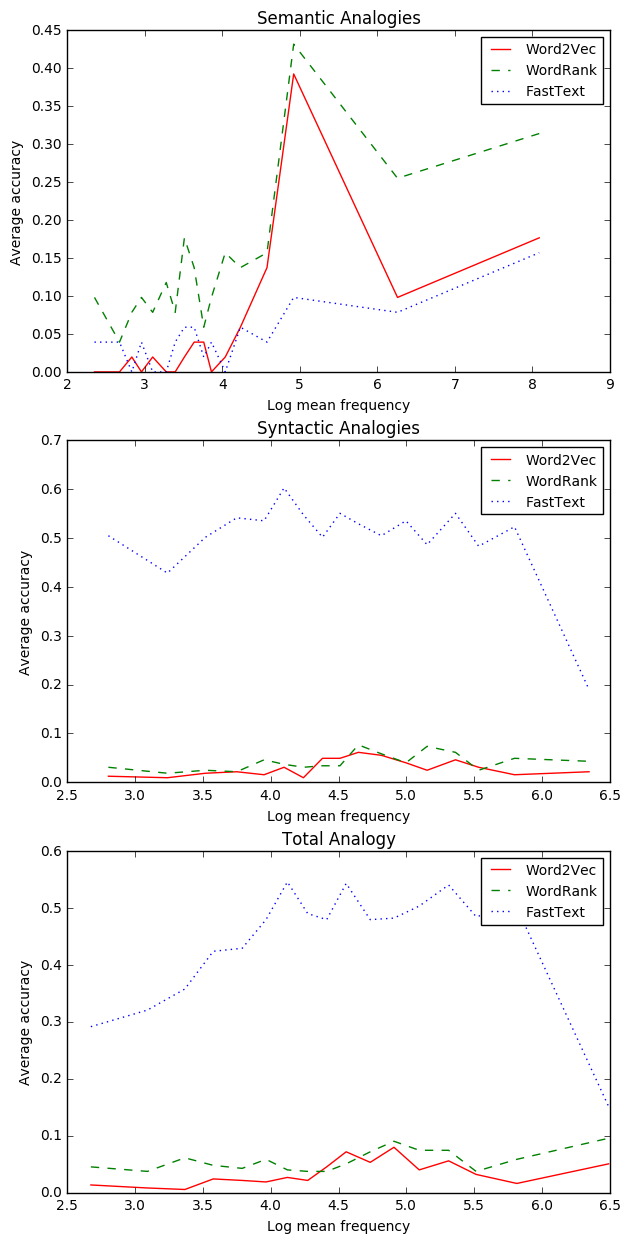

In [9]:
from __future__ import division
import matplotlib.pyplot as plt
import copy
import multiprocessing
import numpy as np


def compute_accuracies(model, freq):
    # mean_freq will contain analogies together with the mean frequency of 4 words involved
    mean_freq = {}
    with open(word_analogies_file, 'r') as r:
        for i, line in enumerate(r):
            if ':' not in line:
                analogy = tuple(line.split())
            else:
                continue
            try:
                mfreq = sum([int(freq[x.lower()]) for x in analogy])/4
                mean_freq['a%d'%i] = [analogy, mfreq]
            except KeyError:
                continue
    
    # compute model's accuracy
    model = KeyedVectors.load_word2vec_format(model)
    acc = model.accuracy(word_analogies_file)
    
    sem_correct = [acc[i]['correct'] for i in range(5)]
    sem_total = [acc[i]['correct'] + acc[i]['incorrect'] for i in range(5)]
    syn_correct = [acc[i]['correct'] for i in range(5, len(acc)-1)]
    syn_total = [acc[i]['correct'] + acc[i]['incorrect'] for i in range(5, len(acc)-1)]
    total_correct = sem_correct + syn_correct
    total_total = sem_total + syn_total

    sem_x, sem_y = calc_axis(sem_correct, sem_total, mean_freq)
    syn_x, syn_y = calc_axis(syn_correct, syn_total, mean_freq)
    total_x, total_y = calc_axis(total_correct, total_total, mean_freq)
    return ((sem_x, sem_y), (syn_x, syn_y), (total_x, total_y))

def calc_axis(correct, total, mean_freq):
    # make flat lists
    correct_analogies = []
    for i in range(len(correct)):
        for analogy in correct[i]:
            correct_analogies.append(analogy)            
    total_analogies = []
    for i in range(len(total)):
        for analogy in total[i]:
            total_analogies.append(analogy)

    copy_mean_freq = copy.deepcopy(mean_freq)
    # delete other case's analogy from total analogies  
    for key, value in copy_mean_freq.items():
        value[0] = tuple(x.upper() for x in value[0])
        if value[0] not in total_analogies:
            del copy_mean_freq[key]

    # append 0 or 1 for incorrect or correct analogy
    for key, value in copy_mean_freq.iteritems():
        value[0] = tuple(x.upper() for x in value[0])
        if value[0] in correct_analogies:
            copy_mean_freq[key].append(1)
        else:
            copy_mean_freq[key].append(0)

    x = []
    y = []
    bucket_size = int(len(copy_mean_freq) * 0.06)
    # sort analogies according to their mean frequences 
    copy_mean_freq = sorted(copy_mean_freq.items(), key=lambda x: x[1][1])
    # prepare analogies buckets according to given size
    for centre_p in xrange(bucket_size//2, len(copy_mean_freq), bucket_size):
        bucket = copy_mean_freq[centre_p-bucket_size//2:centre_p+bucket_size//2]
        b_acc = 0
        # calculate current bucket accuracy with b_acc count
        for analogy in bucket:
            if analogy[1][2]==1:
                b_acc+=1
        y.append(b_acc/bucket_size)
        x.append(np.log(copy_mean_freq[centre_p][1][1]))
    return x, y

# a sample model using gensim's Word2Vec for getting vocab counts
corpus = Text8Corpus('proc_brown_corp.txt')
model = Word2Vec(min_count=5)
model.build_vocab(corpus)
freq = {}
for word in model.wv.index2word:
    freq[word] = model.wv.vocab[word].count

# plot results
word2vec = compute_accuracies('brown_gs.vec', freq)
wordrank = compute_accuracies('brown_wr_ensemble.vec', freq)
fasttext = compute_accuracies('brown_ft.vec', freq)

fig = plt.figure(figsize=(7,15))

for i, subplot, title in zip([0, 1, 2], ['311', '312', '313'], ['Semantic Analogies', 'Syntactic Analogies', 'Total Analogy']):
    ax = fig.add_subplot(subplot)
    ax.plot(word2vec[i][0], word2vec[i][1], 'r-', label='Word2Vec')
    ax.plot(wordrank[i][0], wordrank[i][1], 'g--', label='WordRank')
    ax.plot(fasttext[i][0], fasttext[i][1], 'b:', label='FastText')
    ax.set_ylabel('Average accuracy')
    ax.set_xlabel('Log mean frequency')
    ax.set_title(title)
    ax.legend(loc='upper right', prop={'size':10})

plt.show()

This graph show the results trained over Brown corpus(1 million tokens).

The main observations that can be drawn here are-
1. In Semantic Analogies, all the models perform poorly for rare words as compared to their performance at more frequent words.
2. In Syntactic Analogies, FastText performance is way better than Word2Vec and WordRank.
3. If we go through the frequency range in Syntactic Analogies plot, FastText performance drops significantly at highly frequent words, whereas, for Word2Vec and WordRank there is no significant difference over the whole frequency range.
4. End plot shows the results of combined Semantic and Syntactic Analogies. It has more resemblance to the Syntactic Analogy's plot because the total no. of Syntactic Analogies(=5461) is much greater than the total no. of Semantic ones(=852). So it's bound to trace the Syntactic's results as they have more weightage in the total analogies considered.

Now, let’s see if a larger corpus creates any difference in this pattern of model's performance over different frequencies.

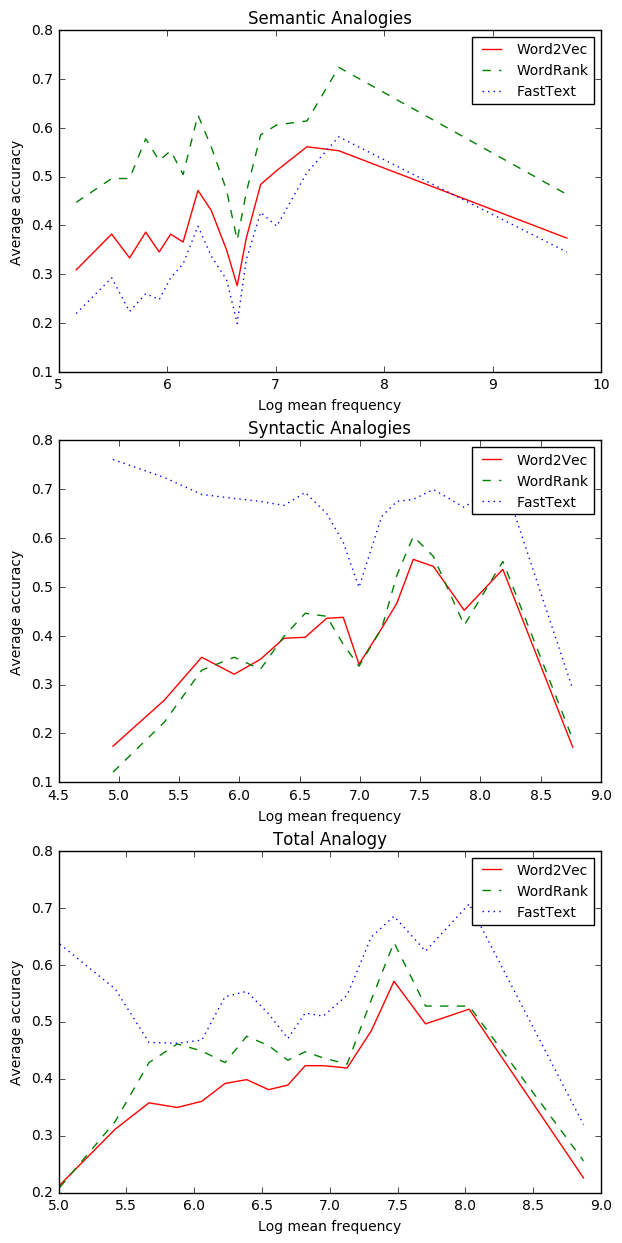

In [10]:
# a sample model using gensim's Word2Vec for getting vocab counts
corpus = Text8Corpus('text8')
model = Word2Vec(min_count=5)
model.build_vocab(corpus)
freq = {}
for word in model.wv.index2word:
    freq[word] = model.wv.vocab[word].count
        
word2vec = compute_accuracies('text8_gs.vec', freq)
wordrank = compute_accuracies('text8_wr.vec', freq)
fasttext = compute_accuracies('text8_ft.vec', freq)

fig = plt.figure(figsize=(7,15))

for i, subplot, title in zip([0, 1, 2], ['311', '312', '313'], ['Semantic Analogies', 'Syntactic Analogies', 'Total Analogy']):
    ax = fig.add_subplot(subplot)
    ax.plot(word2vec[i][0], word2vec[i][1], 'r-', label='Word2Vec')
    ax.plot(wordrank[i][0], wordrank[i][1], 'g--', label='WordRank')
    ax.plot(fasttext[i][0], fasttext[i][1], 'b:', label='FastText')
    ax.set_ylabel('Average accuracy')
    ax.set_xlabel('Log mean frequency')
    ax.set_title(title)
    ax.legend(loc='upper right', prop={'size':10})

plt.show()

This shows the results for text8(17 million tokens). Following points can be observed in this case-

1. For Semantic analogies, all the models perform comparitively poor on rare words and also when the word frequency is high towards the end.
2. For Syntactic Analogies, FastText performance is fairly well on rare words but then falls steeply at highly frequent words.
3. WordRank and Word2Vec perform very similar with low accuracy for rare and highly frequent words in Syntactic Analogies.
4. FastText is again better in total analogies case due to the same reason described previously. Here the total no. of Semantic analogies is 7416 and Syntactic Analogies is 10411.

These graphs also conclude that WordRank is the best suited method for Semantic Analogies, and FastText for Syntactic Analogies for all the frequency ranges and over different corpus sizes, though all the embedding methods could become very competitive as the corpus size increases largerly<sup>[2]</sup>. 

# Conclusions


The experiments here conclude two main points from comparing Word embeddings. Firstly, there is no single global embedding model we could rely on for different types of NLP applications. For example, in Word Similarity, WordRank performed better than the other two algorithms for WS-353 test data whereas, Word2Vec performed better on SimLex-999. This is probably due to the different type of similarities these datasets address<sup>[3]</sup>. And in Word Analogy task, WordRank performed better for Semantic Analogies and FastText for Syntactic Analogies. This basically tells us that we need to choose the embedding method carefully according to our final use-case.

Secondly, our query words do matter apart from the generalized model performance. As we observed in Accuracy vs. Frequency graphs that models perform differently depending on the frequency of question analogy words in training corpus. For example, we are likely to get poor results if our query words are all highly frequent.

*__Note__:* WordRank can sometimes produce NaN values during model evaluation, when the embedding vector values get too diverged at some iterations, but it dumps embedding vectors after every few iterations, so you could just load embeddings from a different iteration’s text file.

# References
1. [WordRank: Learning Word Embeddings via Robust Ranking](https://arxiv.org/pdf/1506.02761v3.pdf)
2. [Word2Vec and FastText comparison notebook](Word2Vec_FastText_Comparison.ipynb)
3. [Similarity test data](https://www.cl.cam.ac.uk/~fh295/simlex.html)